版本1：一个数据输入，划分数据集后训练测试
使用cuda加速

In [34]:
import torch
import torch.nn as nn
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


def modify_data(path, key, mem_n):
    data = scio.loadmat(path)
    data_x = data[key+'_x']
    data_y = data[key+'_y']
    L = len(data_x)
    data_x_temp = np.pad(data_x, ((0, mem_n), (0, 0)), 'wrap').T
    data_x_temp_real = np.real(data_x_temp)
    data_x_temp_imag = np.imag(data_x_temp)
    data_x_new_real = np.zeros([L, mem_n])
    data_x_new_imag = np.zeros([L, mem_n])
    for i in range(L):
        data_x_new_real[i, :] = data_x_temp_real[:, i:mem_n+i]
        data_x_new_imag[i, :] = data_x_temp_imag[:, i:mem_n+i]

    data_y_real = np.real(data_y)
    data_y_imag = np.imag(data_y)
    return data_x_new_real, data_x_new_imag, data_y_real, data_y_imag


def train(epochs, model, x_train, y_train, criterion, optimizer, device):
    train_loss = []
    for i in range(epochs):
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        y_pred = model.forward(x_train)
        loss = criterion(y_pred, y_train)
        train_loss.append(loss.item())
        # if i % 10 == 0:
        #     print(f'Epoch: {i} Loss: {loss}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 绘图代码
    plt.plot(np.arange(len(train_loss)), train_loss, label="train loss")
    plt.legend()  # 显示图例
    plt.xlabel('epoches')
    plt.title('loss')
    # plt.show()

    return model


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(40, 46)
        self.act1 = nn.Tanh()
        self.linear2 = nn.Linear(46, 30)
        self.act2 = nn.Tanh()
        self.linear3 = nn.Linear(30, 24)
        self.act3 = nn.Tanh()
        self.linear4 = nn.Linear(24, 16)
        self.act4 = nn.PReLU(16)
        self.output = nn.Linear(16, 1)

    # 前向传播
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.linear3(x)
        x = self.act3(x)
        x = self.linear4(x)
        x = self.act4(x)
        x = self.output(x)
        return x

cuda:0


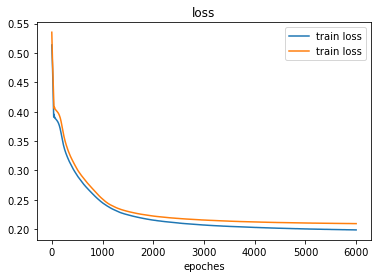

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
mem_n = 40
model_real = Model().to(device)
model_imag = Model().to(device)
loss_real = nn.MSELoss()
loss_imag = nn.MSELoss()

optimizer_real = torch.optim.Adam(model_real.parameters(), lr=0.001)
optimizer_imag = torch.optim.Adam(model_imag.parameters(), lr=0.001)

[X_real, X_imag, Y_real, Y_imag] = modify_data(
    '../data/data_mt_new.mat', 'mt', mem_n)

X_train_real, X_test_real, Y_train_real, Y_test_real = train_test_split(
    X_real, Y_real, test_size=0.2, random_state=42)
X_train_imag, X_test_imag, Y_train_imag, Y_test_imag = train_test_split(
    X_imag, Y_imag, test_size=0.2, random_state=42)

x_train_real = torch.FloatTensor(X_train_real)
y_train_real = torch.FloatTensor(Y_train_real)
x_train_imag = torch.FloatTensor(X_train_imag)
y_train_imag = torch.FloatTensor(Y_train_imag)

model_real = train(6000, model_real, x_train_real,
                   y_train_real, loss_real, optimizer_real, device)
model_imag = train(6000, model_imag, x_train_imag,
                   y_train_imag, loss_imag, optimizer_imag, device)


In [44]:
x_test_real = torch.FloatTensor(X_test_real)
y_test_real = torch.FloatTensor(Y_test_real)
x_test_imag = torch.FloatTensor(X_test_imag)
y_test_imag = torch.FloatTensor(Y_test_imag)

Y_pred_real = []
Y_pred_imag = []
with torch.no_grad():
    x_test = x_test_imag.to(device)
    Y_pred_imag = model_imag.forward(x_test)
    Y_pred_imag = Y_pred_imag.cpu()
    Y_pred_imag = Y_pred_imag.numpy()
        
with torch.no_grad():
    x_test = x_test_real.to(device)
    Y_pred_real = model_real.forward(x_test)
    Y_pred_real = Y_pred_real.cpu()
    Y_pred_real = Y_pred_real.numpy()

In [45]:

Y_test_real = Y_test_real.reshape(-1, 1)
Y_test_real = Y_test_real.reshape(-1, 1)
X_real_new = X_test_real[:, 0].reshape(-1, 1)
X_imag_new = X_test_imag[:, 0].reshape(-1, 1)
scio.savemat('../data_out/E_eq_mt.mat', mdict={'E_tx_mt_real': Y_test_real,
                                               'E_tx_mt_imag': Y_test_imag,
                                               'E_rx_mt_real': X_real_new,
                                               'E_rx_mt_imag': X_imag_new,
                                               'E_eq_mt_real': Y_pred_real,
                                               'E_eq_mt_imag': Y_pred_imag})

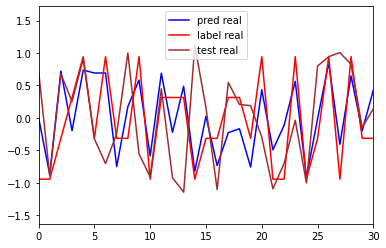

In [46]:
plt.figure(2)
plt.plot(np.arange(len(Y_pred_real)), Y_pred_real, color='blue', label="pred real")
plt.plot(np.arange(len(Y_pred_real)), Y_test_real, color='red', label="label real")
plt.plot(np.arange(len(Y_pred_real)), X_real_new, color='brown', label="test real")
plt.legend()
plt.xlim(0, 30)
plt.show()